# Analysis of stellar spectra


## Background Information on the dataset


You will be working with spectra of stars that have been aquired by the space telescope Gaia (https://www.esa.int/Science_Exploration/Space_Science/Gaia). 

For part of these stars, we have additional information from another observation mission GALAH (https://www.galah-survey.org/) that observed some of these stars as well. This will provide us with some labels for part of the dataset, but we don't (and can't, at the moment) know the "truth" for the stars that have not been observed by GALAH.


spectra are 1D data were each feature corresponds to a wavelength. Here the spectra span a wavelength range of 846–870 nm, with a step of 0.01 nm. 

### Data matrix:

spec_rvs_wise_galah.npy (spectra from Gaia for stars observed by both Gaia and GALAH)  = 21556 spectra of size 2401 each. We refer to it later as spectra_withgalah.
\
spec_NOgalah_rvswise.npy ((spectra from Gaia for stars observed only by Gaia) = 22295 spectra of size 2401 each. we refer to it later as spectraNOgal 

### Additional information dataframe:
gaiaGalah_info_rvswisegalah = information for the stars observed by both GALAH and Gaia (we refer to it later as gaiagal_info)
\
gaia_info_rvswiseNOgalah = information (partial) for the stars only observed by Gaia

### Indexing files:
(This shouldn't be necessary, as the spectra matrix and the dataframe should have the right order, but just in case)

ids_rvs_wise_galah = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "dr3_source_id" in gaiaGalah_info_rvswisegalah
\
ids_NOgalah_rvswise = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "source_id" in gaiaGalah_info_rvswisegalah




Example of a spectrum from the dataset: 

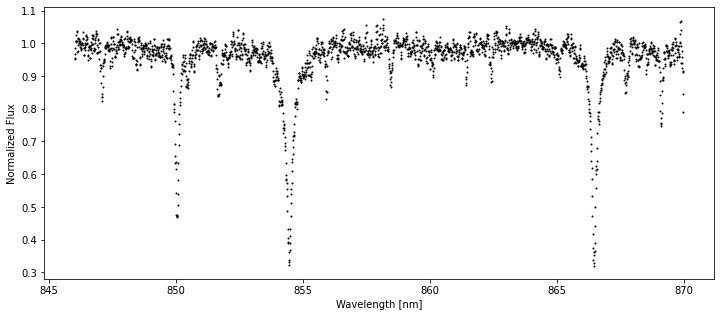


Spectras contain information about the composition of a star through absorbtion and emission lines:


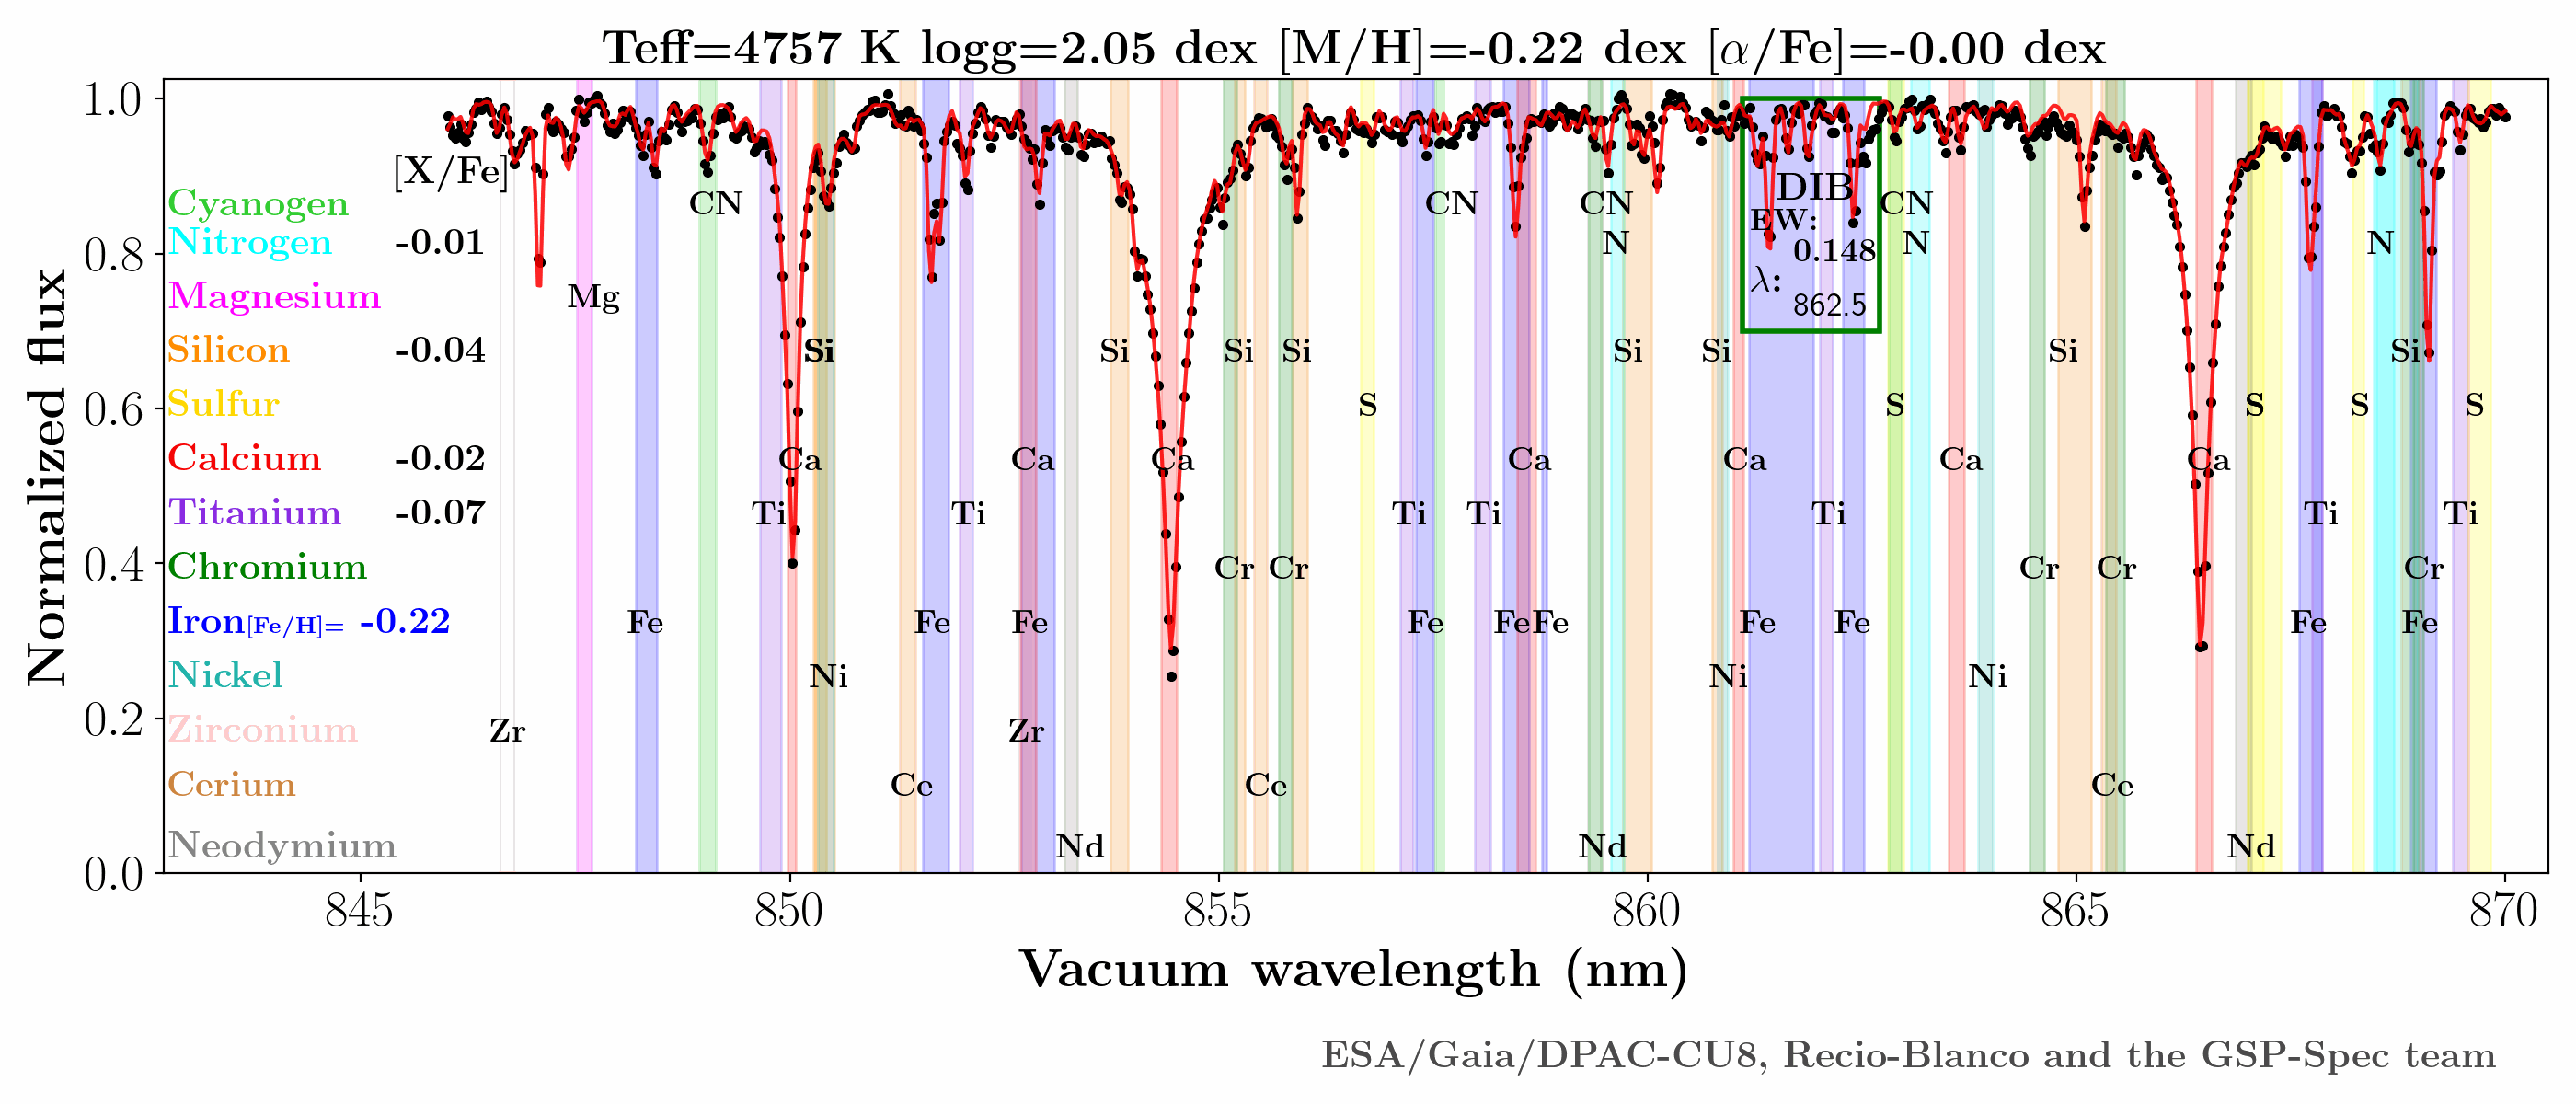

https://www.cosmos.esa.int/web/gaia/iow_20210709#

Different types of stars will have different looking spectras.
However, the spectra we get from Gaia are on a small range of wavelength, and not all interactions/emissions are known, neither necessarily the types of stars! 
On the other hand, GALAH observed those stars at larger wavelengths range (verify) and thus was able to produce some labels about metallicities and so on. 

One question that might be interesting to ask is: is there enough information from the Gaia spectra to predict those labels --we just don't know yet the "physically informed" way of doing it, but maybe it is possible! 

We're also interested in finding out if we see patterns or clusters in our dataset: they might indicate different type of stars (or, spoiler alert, observational issues...). 
Anomalies are also of interest, either finding extremely rare objects that we need to explain, or data impacted by observational artifact (most likely). 

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer



### Pre-processing

The spectra are in normalized flux, so they don't need to much pre-processing. However, **some spectra can contain NaN values; replace those values by the median of the given spectrum (i.e. of that row of the matrix) before carrying on!**  (your code will most likely crash if you don't anyway.)

Note the spectra file are .npy format you can load with numpy; the information tables can be loaded with pandas.

In [2]:
# Load the .npy file using numpy
data_dir = './data/'

spectra_withgalah_np = np.load(data_dir + 'spec_rvs_wise_galah.npy')
spectra_withgalah = pd.DataFrame(spectra_withgalah_np)

spectraNOgal_np = np.load(data_dir + "spec_NOgalah_rvswise.npy")
spectraNOgal = pd.DataFrame(spectraNOgal_np)

gaiagal_info = pd.read_csv(data_dir + "gaia_info_rvswisegalah.csv")
gaiaNOgal_info = pd.read_csv(data_dir + "gaia_info_rvswiseNOgalah.csv")

Print number of NaN

In [3]:
print("Number of NaN for each dataset")
print("Spectra with galah =", spectra_withgalah.isna().sum().sum())
print("Spectra NO gal =", spectraNOgal.isna().sum().sum())
print("Gaia info =", gaiagal_info.isna().sum().sum())
print("Gaia NO gal =", gaiaNOgal_info.isna().sum().sum())

Number of NaN for each dataset
Spectra with galah = 131180
Spectra NO gal = 147436
Gaia info = 704326
Gaia NO gal = 731018


Impute data by the median of the given spectrum

In [4]:
imputer = SimpleImputer(strategy='median')
spectra_withgalah.iloc[:,:] = imputer.fit_transform(spectra_withgalah.iloc[:,:])
spectraNOgal.iloc[:,:] = imputer.fit_transform(spectraNOgal.iloc[:,:])

In [5]:
print("Number of NaN for each dataset")
print("Spectra with galah =", spectra_withgalah.isna().sum().sum())
print("Spectra NO gal =", spectraNOgal.isna().sum().sum())

Number of NaN for each dataset
Spectra with galah = 0
Spectra NO gal = 0


In [6]:
imputer = SimpleImputer(strategy='median')
#gaiagal_info.iloc[:,:] = imputer.fit_transform(gaiagal_info.iloc[:,:])
#gaiaNOgal_info.iloc[:,:] = imputer.fit_transform(gaiaNOgal_info.iloc[:,:])

In [7]:
print("Number of NaN for each dataset")
#print("Gaia info =", gaiagal_info.isna().sum().sum())
#print("Gaia NO gal =", gaiaNOgal_info.isna().sum().sum())

Number of NaN for each dataset


Try to plot a few spectra to see if you see differences between them!

### Metallicity Regression

One measurement that is interesting to astronomers is "metallicity". This can mean different thing, but in the context of this project, we will be considering the column "fe_h" in gaiagal_info. We will use this as our label for the regression task.\
For now, we can only use the spectra_withgalah / gaiagal_info since they are the only ones with this information. Since we need supervision for this task, ensure that you have proper labels for all your spectra --some might have a NaN fe_h! 


Build a pipeline for this regression problem: construct a training and test set from the data, and train models to predict.Try (e.g. using sklearn) RandomForestRegressor (explore different hyper-parameters), LinearRegressor, and KNeighborsRegressor.\
You can plot the true labels (x-axis) vs the predicted labels (y-axis), for the train and test data.\
Summarize the error in prediction (using the Mean Square Error) for the models in a table.


## Visualization and dimensionality reduction exploration

Apply PCA on the spectra_withgalah, and \
  a) plot the explained variance ratio as a function of the number of components; \
  b) plot scatter plots of the lower-dimensional PCA-transformed space using few components (e.g. using the 0th/1st components, 0th/2d); what do you observe? \
  c) plot the first 3 PCA components (i.e. in "spectra" space) 
  
 

Apply PCA on the other spectra dataset (spec_NOgalah_rvswise) and compare the results (specifically b) and c)). 


(Optional): Try another algorithm for visualization/dimensionality reduction like t-SNE or UMAP.

## Clustering

Using the lower dimensional space from PCA (e.g. with even only 2 or 3 components) on the spectraNOgal dataset, run a clustering algorithm to separate your data. \
For each of the cluster you find, plot the average spectra of this cluster. 

## Anomaly Detection 


Run IsolationForest on the spectraNOGal (in high-dimension, not reduced). Find the 5 most anomalous spectra using the score_samples function, and report them back on the PCA projection plot. Plot as well the 5 spectra. What do you observe? 

